# 1. Handling Missing Values

from https://www.kaggle.com/dansbecker/handling-missing-values

#### First, detect which cells have missing values, and then count how many there are in each column with the command:

missing_val_count_by_column = (data.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0]


#### Second, refill missing values...

#### 1) A Simple Option: Drop Columns with Missing Values

    data_without_missing_values = original_data.dropna(axis=1)

or

    cols_with_missing = [col for col in original_data.columns

                                 if original_data[col].isnull().any()]

    redued_original_data = original_data.drop(cols_with_missing, axis=1)

    reduced_test_data = test_data.drop(cols_with_missing, axis=1)

#### 2) A Better Option: Imputation

    from sklearn.impute import SimpleImputer

    my_imputer = SimpleImputer()

    data_with_imputed_values = my_imputer.fit_transform(original_data)

#### 3) An Extension To Imputation

###### make copy to avoid changing original data (when Imputing)
    new_data = original_data.copy()

###### make new columns indicating what will be imputed
    cols_with_missing = (col for col in new_data.columns

                                 if new_data[col].isnull().any())

    for col in cols_with_missing:

    new_data[col + '_was_missing'] = new_data[col].isnull()

##### Imputation
    my_imputer = SimpleImputer()

    new_data = pd.DataFrame(my_imputer.fit_transform(new_data))

    new_data.columns = original_data.columns

### Example

In [1]:
import pandas as pd

# Load data
melb_data = pd.read_csv('./melb_data.csv')

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

melb_target = melb_data.Price
melb_predictors = melb_data.drop(['Price'], axis=1)

# For the sake of keeping the example simple, we'll use only numeric predictors. 
melb_numeric_predictors = melb_predictors.select_dtypes(exclude=['object'])

In [3]:
# Create Function to Measure Quality of An Approach
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(melb_numeric_predictors, 
                                                    melb_target,
                                                    train_size=0.7, 
                                                    test_size=0.3, 
                                                    random_state=0)

def score_dataset(X_train, X_test, y_train, y_test):
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_absolute_error(y_test, preds)

These files will be used in the second part
type(X_train) will give... pandas.core.frame.DataFrame 
    out_train = X_train
    out_train.loc[:,'SalePrice'] = y_train # Add new column
    out_test = X_test
    out_test.loc[:,'SalePrice'] = y_test # Add new column
    out_train.to_csv('./train.csv', sep=',')
    out_test.to_csv('./test.csv', sep=',')

In [4]:
# Get Model Score from Dropping Columns with Missing Values
cols_with_missing = [col for col in X_train.columns 
                                 if X_train[col].isnull().any()]
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_test  = X_test.drop(cols_with_missing, axis=1)
print("Mean Absolute Error from dropping columns with Missing Values:")
print(score_dataset(reduced_X_train, reduced_X_test, y_train, y_test))

Mean Absolute Error from dropping columns with Missing Values:
188532.9994751853


In [7]:
# Get Model Score from Imputation
import sklearn
if sklearn.__version__ <= '0.19.2':
    from sklearn.preprocessing import Imputer
    my_imputer = Imputer()
else:  # Valid for sklearn.__version__ >= '0.21.dev0'
    from sklearn.impute import SimpleImputer
    my_imputer = SimpleImputer()

imputed_X_train = my_imputer.fit_transform(X_train)
imputed_X_test = my_imputer.transform(X_test)
print("Mean Absolute Error from Imputation:")
print(score_dataset(imputed_X_train, imputed_X_test, y_train, y_test))

Mean Absolute Error from Imputation:
182282.04273441332


In [10]:
# Get Score from Imputation with Extra Columns Showing What Was Imputed
imputed_X_train_plus = X_train.copy()
imputed_X_test_plus = X_test.copy()

cols_with_missing = (col for col in X_train.columns 
                                 if X_train[col].isnull().any())
for col in cols_with_missing:
    imputed_X_train_plus[col + '_was_missing'] = imputed_X_train_plus[col].isnull()
    imputed_X_test_plus[col + '_was_missing'] = imputed_X_test_plus[col].isnull()

# Imputation
#my_imputer = SimpleImputer()
imputed_X_train_plus = my_imputer.fit_transform(imputed_X_train_plus)
imputed_X_test_plus = my_imputer.transform(imputed_X_test_plus)

print("Mean Absolute Error from Imputation while Track What Was Imputed:")
print(score_dataset(imputed_X_train_plus, imputed_X_test_plus, y_train, y_test))


Mean Absolute Error from Imputation while Track What Was Imputed:
184628.39606096732


# 2. Using Categorical Data with One Hot Encoding

from https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding

In [25]:
# Read the data
import pandas as pd
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

# Drop houses where the target is missing
train_data.dropna(axis=0, subset=['SalePrice'], inplace=True)

target = train_data.SalePrice

# Since missing values isn't the focus of this tutorial, we use the simplest
# possible approach, which drops these columns. 
# For more detail (and a better approach) to missing values, see
# https://www.kaggle.com/dansbecker/handling-missing-values
cols_with_missing = [col for col in train_data.columns 
                                 if train_data[col].isnull().any()]                                  
candidate_train_predictors = train_data.drop(['Id', 'SalePrice'] + cols_with_missing, axis=1)
candidate_test_predictors = test_data.drop(['Id'] + cols_with_missing, axis=1)

# "cardinality" means the number of unique values in a column.
# We use it as our only way to select categorical columns here. This is convenient, though
# a little arbitrary.
low_cardinality_cols = [cname for cname in candidate_train_predictors.columns if 
                                candidate_train_predictors[cname].nunique() < 10 and
                                candidate_train_predictors[cname].dtype == "object"]
numeric_cols = [cname for cname in candidate_train_predictors.columns if 
                                candidate_train_predictors[cname].dtype in ['int64', 'float64']]
my_cols = low_cardinality_cols + numeric_cols
train_predictors = candidate_train_predictors[my_cols]
test_predictors = candidate_test_predictors[my_cols]

In [26]:
train_predictors.dtypes.sample(10)

LandSlope        object
Foundation       object
BldgType         object
OpenPorchSF       int64
SaleCondition    object
SaleType         object
FullBath          int64
ExterCond        object
HouseStyle       object
3SsnPorch         int64
dtype: object

In [27]:
# It's most common to one-hot encode these "object" columns, since they can't be plugged directly into most models. 
# Pandas offers a convenient function called get_dummies to get one-hot encodings.
one_hot_encoded_training_predictors = pd.get_dummies(train_predictors)
print(len(train_predictors),len(one_hot_encoded_training_predictors))
print(one_hot_encoded_training_predictors)

1460 1460
      MSSubClass  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0             60     8450            7            5       2003          2003   
1             20     9600            6            8       1976          1976   
2             60    11250            7            5       2001          2002   
3             70     9550            7            5       1915          1970   
4             60    14260            8            5       2000          2000   
5             50    14115            5            5       1993          1995   
6             20    10084            8            5       2004          2005   
7             60    10382            7            6       1973          1973   
8             50     6120            7            5       1931          1950   
9            190     7420            5            6       1939          1950   
10            20    11200            5            5       1965          1965   
11            60    11924     

In [22]:
# Are the categorical model features (the one-hot encoded variables) helping the model?
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

def get_mae(X, y):
    # multiple by -1 to make positive MAE score instead of neg value returned as sklearn convention
    return -1 * cross_val_score(RandomForestRegressor(50), 
                                X, y, 
                                scoring = 'neg_mean_absolute_error').mean()

predictors_without_categoricals = train_predictors.select_dtypes(exclude=['object'])

mae_without_categoricals = get_mae(predictors_without_categoricals, target)

mae_one_hot_encoded = get_mae(one_hot_encoded_training_predictors, target)

print('Mean Absolute Error when Dropping Categoricals: ' + str(int(mae_without_categoricals)))
print('Mean Abslute Error with One-Hot Encoding: ' + str(int(mae_one_hot_encoded)))


Mean Absolute Error when Dropping Categoricals: 18651
Mean Abslute Error with One-Hot Encoding: 18061


In [28]:
# Ensure the test data is encoded in the same manner as the training data with the align command:
one_hot_encoded_training_predictors = pd.get_dummies(train_predictors)
one_hot_encoded_test_predictors = pd.get_dummies(test_predictors)
final_train, final_test = one_hot_encoded_training_predictors.align(one_hot_encoded_test_predictors,
                                                                    join='left', # Equivalent of SQL's left join: if there are ever columns that show up in one dataset and not the other, we will keep exactly the columns from our training data. 
                                                                    #join='inner', # Equivalent to SQL inner join: keeping only the columns showing up in both datasets. 
                                                                    axis=1)

# 3. XGBoost: Gradient Boosted Decision Trees algorithm

from https://www.kaggle.com/dansbecker/xgboost

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer

data = pd.read_csv('./train.csv')
data.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = data.SalePrice
X = data.drop(['SalePrice'], axis=1).select_dtypes(exclude=['object'])
train_X, test_X, train_y, test_y = train_test_split(X.as_matrix(), y.as_matrix(), test_size=0.25)

my_imputer = Imputer()
train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)

/Applications/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [33]:
# To install, type on the terminal...
# $ conda install -c conda-forge xgboost
from xgboost import XGBRegressor

my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(train_X, train_y, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [34]:
# make predictions
predictions = my_model.predict(test_X)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error : 16735.32272046233


#### Model Hyperparameters Tuning

XGBoost has a few hyperparameters that can dramatically affect your model's accuracy and training speed. The first hyperparameters you should understand are:

##### n_estimators and early_stopping_rounds

n_estimators specifies how many times to go through the modeling cycle described above.

In the underfitting vs overfitting graph, n_estimators moves you further to the right. Too low a value causes underfitting, which is inaccurate predictions on both training data and new data. Too large a value causes overfitting, which is accurate predictions on training data, but inaccurate predictions on new data (which is what we care about). You can experiment with your dataset to find the ideal. Typical values range from 100-1000, though this depends a lot on the learning rate discussed below.

The argument early_stopping_rounds offers a way to automatically find the ideal value. Early stopping causes the model to stop iterating when the validation score stops improving, even if we aren't at the hard stop for n_estimators. It's smart to set a high value for n_estimators and then use early_stopping_rounds to find the optimal time to stop iterating.

Since random chance sometimes causes a single round where validation scores don't improve, you need to specify a number for how many rounds of straight deterioration to allow before stopping. early_stopping_rounds = 5 is a reasonable value. Thus we stop after 5 straight rounds of deteriorating validation scores.

In [35]:
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

When using early_stopping_rounds, you need to set aside some of your data for checking the number of rounds to use. If you later want to fit a model with all of your data, set n_estimators to whatever value you found to be optimal when run with early stopping.

##### learning_rate

Here's a subtle but important trick for better XGBoost models:

Instead of getting predictions by simply adding up the predictions from each component model, we will multiply the predictions from each model by a small number before adding them in. This means each tree we add to the ensemble helps us less. In practice, this reduces the model's propensity to overfit.

So, you can use a higher value of n_estimators without overfitting. If you use early stopping, the appropriate number of trees will be set automatically.

In general, a small learning rate (and large number of estimators) will yield more accurate XGBoost models, though it will also take the model longer to train since it does more iterations through the cycle.

In [36]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

##### n_jobs

On larger datasets where runtime is a consideration, you can use parallelism to build your models faster. It's common to set the parameter n_jobs equal to the number of cores on your machine. On smaller datasets, this won't help.

The resulting model won't be any better, so micro-optimizing for fitting time is typically nothing but a distraction. But, it's useful in large datasets where you would otherwise spend a long time waiting during the fit command.

# 4. Partial-Dependence Plots

These type of plots show how each variable or predictor affects the model's predictions.

from https://www.kaggle.com/dansbecker/partial-dependence-plots

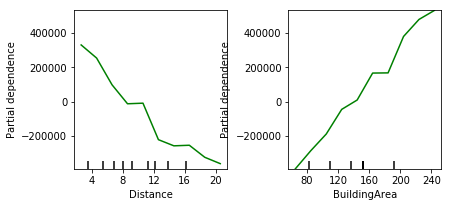

In [41]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.preprocessing import Imputer

cols_to_use = ['Distance', 'Landsize', 'BuildingArea']

def get_some_data():
    data = pd.read_csv('./melb_data.csv')
    y = data.Price
    X = data[cols_to_use]
    my_imputer = Imputer()
    imputed_X = my_imputer.fit_transform(X)
    return imputed_X, y
    

X, y = get_some_data()
my_model = GradientBoostingRegressor()
my_model.fit(X, y)
my_plots = plot_partial_dependence(my_model, 
                                   features=[0,2], 
                                   X=X, 
                                   feature_names=cols_to_use, 
                                   grid_resolution=10)

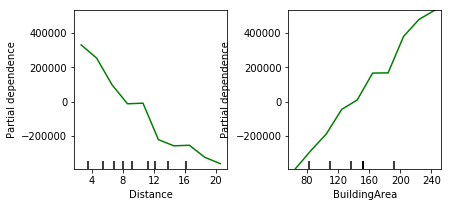

In [42]:
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

# get_some_data is defined in cell above.
X, y = get_some_data()
# scikit-learn originally implemented partial dependence plots only for Gradient Boosting models
# this was due to an implementation detail, and a future release will support all model types.
my_model = GradientBoostingRegressor()
# fit the model as usual
my_model.fit(X, y)
# Here we make the plot
my_plots = plot_partial_dependence(my_model,       
                                   features=[0, 2], # column numbers of plots we want to show
                                   X=X,            # raw predictors data.
                                   feature_names=['Distance', 'Landsize', 'BuildingArea'], # labels on graphs
                                   grid_resolution=10) # number of values to plot on x axis


Some tips related to plot_partial_dependence:

- The features are the column numbers from the X array or dataframe that you wish to have plotted. This starts to look bad beyond 2 or 3 variables. You could make repeated calls to plot 2 or 3 at a time.

- There are options to establish what points on the horizontal axis are plotted. The simplest is grid_resolution which we use to determine how many different points are plotted. These plots tend to look jagged as that value increases, because you will pick up lots of randomness or noise in your model. It's best not to take the small or jagged fluctuations too literally. Smaller values of grid_resolution smooth this out. It's also much less of an issue for datasets with many rows.

- There is a function called partial_dependence to get the raw data making up this plot, rather than making the visual plot itself. This is useful if you want to control how it is visualized using a plotting package like Seaborn. With moderate effort, you could make much nicer looking plots.

# 5. Pipelines

A pipeline bundles preprocessing and modeling steps so you can use the whole bundle as if it were a single step. Benefits include cleaner and more elegant code, fewer bugs, easier-to-productionize code, and more options for model testing (e.g., cross validation).

from https://www.kaggle.com/dansbecker/pipelines 

In [49]:
# Load the data
import pandas as pd
from sklearn.model_selection import train_test_split

# Read Data
data = pd.read_csv('./melb_data.csv')
cols_to_use = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
X = data[cols_to_use]
y = data.Price
train_X, test_X, train_y, test_y = train_test_split(X, y)

In [50]:
# Bundling a modeling process that uses...
# - an Imputer to fill in missing values, with 
# - a RandomForestRegressor to make predictions. 

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer

my_pipeline = make_pipeline(Imputer(), RandomForestRegressor())  # Pipeline must start with transformers-object steps and end with a models-object step.

# Use the Pipeline as a fused whole
my_pipeline.fit(train_X, train_y)
predictions = my_pipeline.predict(test_X)

For comparison, here is the code to do the same thing without pipelines:
    
    my_imputer = Imputer()
    my_model = RandomForestRegressor()

    imputed_train_X = my_imputer.fit_transform(train_X)
    imputed_test_X = my_imputer.transform(test_X)
    my_model.fit(imputed_train_X, train_y)
    predictions = my_model.predict(imputed_test_X)

# 6. Cross-Validation

if our dataset is smaller, we should run cross-validation. Otherwise, a simple train-test split is sufficient for larger datasets. 

There's no simple threshold for what constitutes a large vs small dataset. If your model takes a couple minute or less to run, it's probably worth switching to cross-validation.

Alternatively, you can run cross-validation and see if the scores for each experiment seem close. If each experiment gives the same results, train-test split is probably sufficient.

from https://www.kaggle.com/dansbecker/cross-validation

In [63]:
# Load the data
import pandas as pd
data = pd.read_csv('./melb_data.csv')
cols_to_use = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
X = data[cols_to_use]
y = data.Price

In [64]:
# specify a pipeline of modeling steps
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
my_pipeline = make_pipeline(Imputer(), RandomForestRegressor())

In [68]:
# Get cross-validation scores
# Recall that Scikit-learn has a convention where all metrics are defined so a high number is better (that's why NEGATIVE mean_abs_error.
from sklearn.model_selection import cross_val_score
scores = cross_val_score(my_pipeline, X, y, cv=5,scoring='neg_mean_absolute_error')  # For other scoring arguments, see http://scikit-learn.org/stable/modules/model_evaluation.html 
print(scores)  # Note that if cv is not given, cross_val_score will use cv=3 folds by default, that is one holdout fold for validation and two holdin folds for training.

[-312865.49752141 -308338.11133546 -296051.08715304 -248864.4014016
 -266151.19477723]


In [69]:
# Obtain single measure of model quality to compare between models. So we take the average across experiments.
print('Mean Absolute Error %2f' %(-1 * scores.mean()))

Mean Absolute Error 286454.058438


# 7. Data Leakage

There are two main types of leakage: Leaky Predictors and a Leaky Validation Strategies.

**Leaky Predictors** occur when your predictors include data that will not be available at the time you make predictions. To prevent it, any variable updated (or created) after the target value is realized should be excluded. Because when we use this model to make new predictions, that data won't be available to the model.

For **Leaky Validation Strategies**, consider that validation is meant to be a measure of how the model does on data it hasn't considered before. One can corrupt this process in subtle ways if the validation data affects the preprocessing behavoir. For example, this happens if you run preprocessing (like fitting the Imputer for missing values) before calling train_test_split. To prevent Leaky Validation Strategies, do the preprocessing inside a pipeline. If your validation is based on a simple train-test split, exclude the validation data from any type of fitting, including the fitting of preprocessing steps. 


from https://www.kaggle.com/dansbecker/data-leakage

Example:

We will use a small dataset about credit card applications, and we will build a model predicting which applications were accepted (stored in a variable called card).

In [87]:
# Load data
import pandas as pd

data = pd.read_csv('./AER_credit_card_data.csv', 
                   true_values = ['yes'],
                   false_values = ['no'])
print(data.head())

   card  reports       age  income     share  expenditure  owner  selfemp  \
0  True        0  37.66667  4.5200  0.033270   124.983300   True    False   
1  True        0  33.25000  2.4200  0.005217     9.854167  False    False   
2  True        0  33.66667  4.5000  0.004156    15.000000   True    False   
3  True        0  30.50000  2.5400  0.065214   137.869200  False    False   
4  True        0  32.16667  9.7867  0.067051   546.503300   True    False   

   dependents  months  majorcards  active  
0           3      54           1      12  
1           3      34           1      13  
2           4      58           1       5  
3           0      25           1       7  
4           2      64           1       5  


In [91]:
data.shape

(1319, 12)

In [92]:
# We can see with data.shape that this is a small dataset (1319 rows), 
# so we should use cross-validation to ensure accurate measures of model quality

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

y = data.card
X = data.drop(['card'], axis=1)

# Since there was no preprocessing, we didn't need a pipeline here. Used anyway as best practice
modeling_pipeline = make_pipeline(RandomForestClassifier())
cv_scores = cross_val_score(modeling_pipeline, X, y, scoring='accuracy')
print("Cross-val accuracy: %f" %cv_scores.mean())

Cross-val accuracy: 0.978011


With experience, you'll find that it's very rare to find models that are accurate 98% of the time. It happens, but it's rare enough that we should inspect the data more closely to see if it is target leakage.

Here is a summary of the data, which you can also find under the data tab:

    card: Dummy variable, 1 if application for credit card accepted, 0 if not
    reports: Number of major derogatory reports
    age: Age n years plus twelfths of a year
    income: Yearly income (divided by 10,000)
    share: Ratio of monthly credit card expenditure to yearly income
    expenditure: Average monthly credit card expenditure
    owner: 1 if owns their home, 0 if rent
    selfempl: 1 if self employed, 0 if not.
    dependents: 1 + number of dependents
    months: Months living at current address
    majorcards: Number of major credit cards held
    active: Number of active credit accounts

A few model features look suspicious. For example, does expenditure mean expenditure on this card or on cards used before appying?

In [96]:
expenditures_cardholders = data.expenditure[data.card]
expenditures_noncardholders = data.expenditure[~data.card]

print('Fraction of those who received a card with no expenditures: %.2f' \
      %(( expenditures_cardholders == 0).mean()))  # Sum of all True values (1's) divided by the number of rows
print('Fraction of those who did NOT received a card with no expenditures: %.2f' \
      %((expenditures_noncardholders == 0).mean())) # Sum of all True values (1's) divided by the number of rows

Fraction of those who received a card with no expenditures: 0.02
Fraction of those who did NOT received a card with no expenditures: 1.00


This seems a data leak, where expenditures probably means **expenditures on the card they applied for.**.

Since **share** is partially determined by **expenditure**, it should be excluded too. 

The variables **active** and **majorcards** are a little less clear, but from the description, they sound concerning. 

In most situations, it's better to be safe than sorry if you can't track down the people who created the data to find out more.

In [97]:
# Run a model without leakage
potential_leaks = ['expenditure', 'share', 'active', 'majorcards']
X2 = X.drop(potential_leaks, axis=1)
cv_scores = cross_val_score(modeling_pipeline, X2, y, scoring='accuracy')
print("Cross-val accuracy: %f" %cv_scores.mean())

Cross-val accuracy: 0.808187


This accuracy is quite a bit lower, which on the one hand is disappointing. However, we can expect it to be right about 80% of the time when used on new applications, whereas the leaky model would likely do much worse then that (even in spite of it's higher apparent score in cross-validation.).

**In Conclusion:** Data leakage can be multi-million dollar mistake in many data science applications. Careful separation of training and validation data is a first step, and pipelines can help implement this separation. Leaking predictors are a more frequent issue, and leaking predictors are harder to track down. A combination of caution, common sense and data exploration can help identify leaking predictors so you remove them from your model.

# 8. Advanced Pipelines & Grid Search Cross Validation

from https://www.kaggle.com/aashita/advanced-pipelines-tutorial


In [81]:
# Load data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import warnings 
warnings.filterwarnings('ignore')

# Read Data
data = pd.read_csv('./melb_data.csv')
cols_to_use = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
X = np.array(data[cols_to_use])
y = data.Price
train_X, val_X, train_y, val_y = train_test_split(X, y)

In [82]:
# Build the Pipeline
# Use Imputer to fill in missing values, followed by a XGBRegressor to make predictions.
# Use Pipeline (instead of make_pipeline) to have a name for every step in our pipeline, so that we can call on a step and set parameters.
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

my_pipeline = Pipeline([ ('imputer', Imputer()), ('xgbrg', XGBRegressor()) ])


In [83]:
# GridSearchCV for tuning the model
from sklearn.model_selection import GridSearchCV

# dictionary for the values of parameters that we want to compare
param_grid = {
    "xgbrg__n_estimators": [10, 50, 100, 500],
    "xgbrg__learning_rate": [0.1, 0.5, 1],
}

# add the name of the regression (here xgbrg__) in front of the parameters' names in the param_grid 
fit_params = {"xgbrg__eval_set": [(val_X, val_y)], 
              "xgbrg__early_stopping_rounds": 10, 
              "xgbrg__verbose": False} 

# using 5-fold cross validation, cv = 5
searchCV = GridSearchCV(my_pipeline, cv=5, param_grid=param_grid, fit_params=fit_params)
searchCV.fit(train_X, train_y)  

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('xgbrg', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_dep...       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params={'xgbrg__eval_set': [(array([[3.00e+00, 1.20e+01, ...,      nan,      nan],
       [4.00e+00, 9.30e+00, ..., 2.15e+02, 1.97e+03],
       ...,
       [2.00e+00, 1.60e+00, ...,      nan,      nan],
       [5.00e+00, 9.90e+00, ..., 1.66e+02, 1.95e+03]]), 12825     900000.0
1857     1570000.0... Price, Length: 3395, dtype: float64)], 'xgbrg__early_stopping_rounds': 10, 'xgbrg__verbose': False},
       iid=True, n_jobs=1,
       param_grid={'xgbrg__n_estimators': [10, 50, 100, 500], 'xgbrg__learning_rate': [0.1, 0.5, 1]},
       

Recall that the number of trees in XGBoost models, that is n_estimators, are tuned by using early_stopping_rounds. The early stopping is decided by checking the prediction of the trained models on a validation set, and hence it is required that we pass an eval_set alongside the early_stopping_rounds in the fit_params.

 One can also sue Random Search for tuning the model
    
    from sklearn.preprocessing import Imputer
    #from xgboost import XGBClassifier
    from xgboost import XGBRegressor
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import RandomizedSearchCV
    import scipy.stats as st 

    #my_pipeline2 = Pipeline([('imputer',  Imputer()),  ('xgbcl',  XGBClassifier())])
    my_pipeline = Pipeline([ ('imputer', Imputer()), ('xgbrg', XGBRegressor()) ])

    params2 = { "xgbcl__n_estimators":  st.randint(3, 50),
               "xgbcl__learning_rate":  st.uniform(0.05, 1)}
    fit_params2 =  {"xgbcl__eval_set": [(val_X, val_y)],            
                   "xgbcl__early_stopping_rounds":  10} 

    searchCV2 =  RandomizedSearchCV(my_pipeline2,  cv=5,  param_distributions=params2, 
                                   fit_params=fit_params2)
    searchCV2.fit(train_X, train_y)

In [74]:
# Find the best hyperparameters
searchCV.best_params_ 

{'xgbrg__learning_rate': 0.1, 'xgbrg__n_estimators': 50}

In [75]:
searchCV.cv_results_['mean_train_score']

array([0.04802058, 0.58715505, 0.58715505, 0.58715505, 0.57831235,
       0.57831235, 0.57831235, 0.57831235, 0.55767936, 0.55923833,
       0.55923833, 0.55923833])

In [76]:
searchCV.cv_results_['mean_test_score']

array([0.03770821, 0.55842203, 0.55842203, 0.55842203, 0.5499774 ,
       0.5499774 , 0.5499774 , 0.5499774 , 0.53095758, 0.53219691,
       0.53219691, 0.53219691])

In [77]:
searchCV.cv_results_['mean_train_score'].mean(), searchCV.cv_results_['mean_test_score'].mean()

(0.5298441230570536, 0.503369349220988)